In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cupy

In [ ]:
mean = 0
std = 1 
num_samples = 100000

noiseData = np.random.normal(mean, std, size=num_samples)

plt.plot(noiseData)


In [ ]:
def genTimeData(spurFreq, 
            spurAmp,
            mean,
            std, 
            numSamples,
            sampleRate):
    
    data = np.random.normal(mean, std, size=numSamples)
    timeArr = np.asarray([i for i in range(0, numSamples)])/sampleRate
    spur = spurAmp * np.sin(2*np.pi * spurFreq * timeArr)
    return data + spur

'''
plt.plot(genTimeData(spurFreq = 299,
                     spurAmp = 1,
                     mean = 0,
                     std = 0,
                     numSamples = 100,
                     sampleRate = 600))
'''
spurFreq = 125.64532344
spurAmp = .2
mean = 0
std = 1
numSamples = 1000
sampleRate = 600
timeArr = np.asarray([i for i in range(0, numSamples)])/sampleRate

timeData = genTimeData(spurFreq, 
            spurAmp,
            mean,
            std, 
            numSamples,
            sampleRate)

fft = np.fft.fft(timeData)
magFft = np.abs(fft[1:(numSamples//2)]) #throw out DC and second half of fft from imaginary part 
powerSpec = 2*magFft**2 

fftFreqs = np.linspace(0, sampleRate//2, numSamples//2)[1:]
#print(fftFreqs)

#plt.plot( fft)
plt.figure()
plt.plot(timeData)
plt.figure()
plt.plot(fftFreqs, powerSpec)
#magFft



In [2]:
class genData:
    '''
    Inputs
    ------------------------
    sigFreqs: array-like
        Frequencies to generate signals. 
        [MHz] 
    sigAmps: array-like
        Amplitudes for signals. 
        Units linear and proportional to voltage, but arbitrary
        Must be same length as sigFreqs 
    mean: float
        mean value for noise
    std: float
        standard deviation of noise
    numSamples: float
        numbers of samples to capture. Twice as long as the fft
    sampleRate: float
        rate samples are captured 
        [MHz]
    numAvg: int
        number of averages to be computed using averaging methods
    
    
    Attributes
    ------------------------
    timeArr: np array
        array of times which signal is sampled by ADC
        [us]
    freqs: np array
        frequencies corosponding to bins of fft
        [MHz]
    
    '''
    def __init__(self,
            sigFreqs, 
            sigAmps,
            mean,
            std, 
            numSamples,
            sampleRate,
            numAvg):
        
        #check for valid args
        if len(sigFreqs) != len(sigAmps):
            raise ValueError('sigFreqs and sigAmps must be same length')
        
        #assign attributes to args
        self.sigFreqs = sigFreqs
        self.sigAmps = sigAmps
        self.mean = mean
        self.std = std
        self.numSamples = numSamples
        self.numAvg = numAvg
        
        #compute additional attributes
        self._halfNumSamples = self.numSamples//2
        self.sampleRate = sampleRate
        self.timeArr = np.asarray([i for i in range(0, self.numSamples)])/self.sampleRate
        self._signals = np.zeros(len(self.timeArr))
        for i in range(len(self.sigFreqs)):
            self._signals += self.sigAmps[i] * np.sin(2*np.pi * self.sigFreqs[i] * self.timeArr)
        self.freqs = np.linspace(0, self.sampleRate//2, self.numSamples//2)[1:]
        self.genTimeData()
        
        '''
        ###Testing 8bit###
        self._signals = np.zeros(len(self.timeArr), dtype = np. int8)
        for i in range(len(self.sigFreqs)):
            self._signals += np.rint(self.sigAmps[i] * np.sin(2*np.pi * self.sigFreqs[i] * self.timeArr))
        '''
        
    def genTimeData(self):
        '''
        Seperates all math which relies on random noise. 
        Ran everytime new data is 'acquired', so slightly optimized
        '''
        noiseData = np.random.normal(self.mean, self.std, size=self.numSamples)
        self.timeData = noiseData + self._signals
        
        #throw out DC and second half of fft from imaginary part 
        self.fft = np.abs(np.fft.fft(self.timeData)[1:(self._halfNumSamples)])  
        
        self.powSpec = 2*self.fft**2
        
        #uncomment to save powSpec in dB. about 20ms/call for 2**24 pt fft
        #self.powSpecdB = 10*np.log10(self.powSpec)
        
    def genTimeDataGpu(self):
        '''
        Seperates all math which relies on random noise. 
        Ran everytime new data is 'acquired', so slightly optimized
        '''
        noiseData = np.random.normal(self.mean, self.std, size=self.numSamples)
        self.timeData = noiseData + self._signals
        
        #throw out DC and second half of fft from imaginary part 
        self.fft = np.abs(cupy.fft.fft(self.timeData)[1:(self._halfNumSamples)])  
        
        self.powSpec = 2*self.fft**2
        
        #uncomment to save powSpec in dB. about 20ms/call for 2**24 pt fft
        #self.powSpecdB = 10*np.log10(self.powSpec)
        
    def genTimeData8Bit(self):
        noiseData = np.asarray(
            np.rint(np.random.normal(mean, std, 2**24)), dtype = np. int8)
        self.timeData = noiseData + self._signals
        
        #throw out DC and second half of fft from imaginary part 
        self.fft = np.abs(np.fft.fft(self.timeData)[1:(self._halfNumSamples)])  
        
        self.powSpec = 2*self.fft**2
        
        #uncomment to save powSpec in dB. about 20ms/call for 2**24 pt fft
        #self.powSpecdB = 10*np.log10(self.powSpec)

        
    def computePowAvg(self):
        self.powAvg = self.powSpec
        for i in range(1, self.numAvg):
            #print(i)
            self.genTimeData()
            self.powAvg = self.powAvg * (i-1)/i + self.powSpec/i

    def setNumAvg(self, numAvg):
        self.numAvg = numAvg


In [106]:

mean = 0
std = 30
signals = np.zeros(1000, dtype = np. int8)
ints8bit = [i for i in range(-128,128)]
gaussList = [np.exp(-1/2 * (((x - mean)/std))**2)
           for x in ints8bit]
normilizedGaussList = gaussList / sum(gaussList)

ints8bit = np.asarray(ints8bit, np. int8)
normilizedGaussArr = np.asarray(normilizedGaussList, dtype = np. float16)
plt.plot(ints8bit, gaussList)
print(sum(normilizedGaussList))
len(gaussList)

0.9999999999999994


256

In [107]:
type(ints8bit[3])

numpy.int8

In [108]:
%%timeit
np.random.choice(ints8bit, 2**24, p = normilizedGaussList)


739 ms ± 914 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [109]:
%%timeit
np.random.normal(mean, std, 2**24)

301 ms ± 241 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [111]:
%%timeit
np.rint(np.random.normal(mean, std, 2**24))

326 ms ± 436 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [112]:
%%timeit
np.asarray(np.rint(np.random.normal(mean, std, 2**24)), dtype = np. int8)

335 ms ± 389 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [119]:
type((np.asarray(np.rint(np.random.normal(mean, std, 2**24)), dtype = np. int8)[67]))

numpy.int8

In [64]:
myData = genData(sigFreqs = [123.456, 49.423],
                     sigAmps = [.0001, .015],
                     mean = 127,
                     std = 30,
                     numSamples = 2**24,
                     sampleRate = 600,
                     numAvg = 1)


In [5]:
%%timeit
fftout = np.abs(np.fft.fft(myData.timeData)[1:300])

6.61 µs ± 20.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [7]:
%%timeitmyData.timeData
timeDataGpu = cupy.asarray(myData.timeData)

13 µs ± 91.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


cupy.core.core.ndarray

In [8]:
#%%timeit
fftoutGpu = np.abs(cupy.fft.fft(timeDataGpu)[1:300])

In [ ]:
np.abs(cupy.fft.fft(self.timeData)[1:(self._halfNumSamples)])

In [ ]:
#%%timeit
myData.genTimeDataGpu()

In [9]:
plt.figure()
plt.plot(myData.freqs, 10*np.log10(fftmyData.timeDataOutGpu))

NameError: name 'fftOutGpu' is not defined

<Figure size 432x288 with 0 Axes>

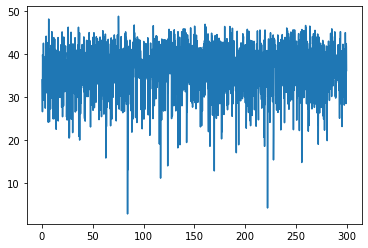

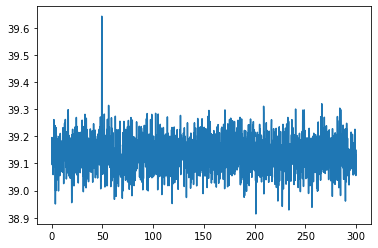

In [300]:
myData.genTimeData()
myData.computePowAvg()

plt.plot(myData.freqs, 10*np.log10(myData.powSpec))
#plt.figure()
#plt.plot(myData.freqs, myData.powSpec)
#plt.figure()
#plt.plot(myData.timeData)
plt.figure()
plt.plot(myData.freqs, 10*np.log10(myData.powAvg))

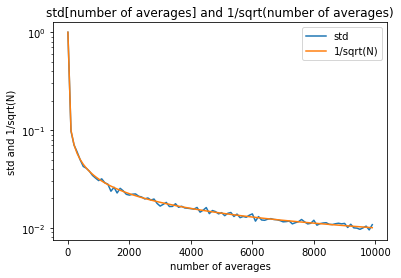

In [267]:
myData = genData(sigFreqs = [],
                     sigAmps = [],
                     mean = 0,
                     std = .1,
                     numSamples = 2**12,
                     sampleRate = 600,
                     numAvg = 300)
 
stdList = []
numAvgRange = range(1,10000,100)


for i in numAvgRange:
    myData.setNumAvg(i)
    myData.genTimeData()
    myData.computePowAvg()
    stdList.append(myData.powAvg.std()/myData.powSpec.std())

#plt.yscale('log')
plt.title('std[number of averages] and 1/sqrt(number of averages)')
plt.xlabel('number of averages')
plt.ylabel('std and 1/sqrt(N)')
plt.semilogy(numAvgRange, stdList, label = 'std')
plt.semilogy(numAvgRange, (1/np.sqrt(numAvgRange)), label = '1/sqrt(N)')
plt.legend()

In [155]:
termData = genData(sigFreqs = [150, 200, 250],
                     sigAmps = [1, .1, .01],
                     mean = 0,
                     std = .1,
                     numSamples = 2**12,
                     sampleRate = 600,
                     numAvg = 30000)

antData = genData(sigFreqs = [123.456, 150, 200, 250],
                     sigAmps = [.01, 1, .1, .01],
                     mean = 0,
                     std = .1,
                     numSamples = 2**12,
                     sampleRate = 600,
                     numAvg = 30000)

In [156]:
plt.close('all')
plt.plot(antData.freqs, 10*np.log10(antData.powSpec))
plt.plot(termData.freqs, 10*np.log10(termData.powSpec))

dif = antData.powSpec - termData.powSpec
plt.figure()
plt.plot(termData.freqs, 10*np.log10(dif))


/tmp/ipykernel_2280108/3747434472.py:7: RuntimeWarning: invalid value encountered in log10
  plt.plot(termData.freqs, 10*np.log10(dif))


In [153]:
plt.close('all')
dif = antData.powSpec - termData.powSpec
plt.plot(termData.freqs, 10*np.log10(dif))

/tmp/ipykernel_2280108/2136921589.py:3: RuntimeWarning: invalid value encountered in log10
  plt.plot(termData.freqs, 10*np.log10(dif))


In [157]:
plt.close('all')
ratio = antData.powSpec / termData.powSpec
plt.plot(termData.freqs, 10*np.log10(dif))

/tmp/ipykernel_2280108/250295076.py:3: RuntimeWarning: invalid value encountered in log10
  plt.plot(termData.freqs, 10*np.log10(dif))


In [55]:
ints8bit = [i for i in range(0,257)]
ints2bit = [i for i in range(-1, 1)]

In [73]:
%%timeit
np.asarray(np.digitize(myData.timeData, ints8bit), dtype = np. int8)

621 ms ± 900 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
myData.timeData

array([464.59093151, 468.91430861, 713.11999865, 380.76589512,
       435.7988138 , 520.94506275, 658.02000649, 441.56457269,
       470.12417575, 762.02175492, 399.65219687, 722.94909304,
       453.33346402, 600.14601458, 425.11274783, 488.32732946])

In [50]:
ints8bit

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
